In [4]:
import sys 
sys.path.append('../')
import os
from deephive.environment.deephive_utils import *
from deephive.environment.utils import *
import numpy as np 
from deephive.exploration.gp_surrogate import GPSurrogateModule
from deephive.environment.utils import filter_points
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process.kernels import Matern
from dotenv import load_dotenv
load_dotenv()
import matplotlib.pyplot as plt

In [5]:
# #Experiment 1: VARIANCE DRIVEN EXPLORERS AND EXPLOITERS
config_path = "../config/exp_config.json"
model_path = "../models/pbest_unfreeze.pth"
mode = "test"
env, agent_policy = initialize(config_path, mode=mode, model_path=model_path)
config = parse_config(config_path)

Loaded policy from:  ../models/pbest_unfreeze.pth


In [6]:
timestep = 20
obs, role = env.reset()
for i in range(timestep):
    agent_policy.std_controller.update_roles(role)
    observation_std = agent_policy.std_controller.get_all_std()
    print(observation_std)
    action = get_action(obs, observation_std, agent_policy, env)
    obs, reward, done, info = env.step(action)
    obs, role = obs
    agent_policy.std_controller.decay_std()
    
    

[[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2], [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]]
[[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2], [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]]
[[0.198, 0.198, 0.198, 0.198, 0.198, 0.198, 0.198, 0.198, 0.198, 0.198], [0.198, 0.198, 0.198, 0.198, 0.198, 0.198, 0.198, 0.198, 0.198, 0.198]]
[[0.1940598, 0.1940598, 0.1940598, 0.1940598, 0.1940598, 0.1940598, 0.1940598, 0.1940598, 0.1940598, 0.1940598], [0.1940598, 0.1940598, 0.1940598, 0.1940598, 0.1940598, 0.1940598, 0.1940598, 0.1940598, 0.1940598, 0.1940598]]
[[0.1882960298802, 0.1882960298802, 0.1882960298802, 0.1882960298802, 0.1882960298802, 0.1882960298802, 0.1882960298802, 0.1882960298802, 0.1882960298802, 0.1882960298802], [0.1882960298802, 0.1882960298802, 0.1882960298802, 0.1882960298802, 0.1882960298802, 0.1882960298802, 0.1882960298802, 0.1882960298802, 0.1882960298802, 0.1882960298802]]
[[0.18087641500176088, 0.18087641500176088, 0.18087641500176088, 0.18087641

In [28]:
std_controller = StdController(num_agents=env.n_agents, n_dim=env.n_dim,
                               role_std={"explorer": 0.2, "exploiter": 0.1}, decay_rate=0.99,
                               min_std=0.02, max_std=0.3)
std_controller.std

[[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2],
 [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]]

In [46]:
std_controller.iteration_num

100

In [45]:
std_controller.decay_std()
std_controller.std

[[0.026795934971592352,
  0.02,
  0.026795934971592352,
  0.02,
  0.026795934971592352,
  0.02,
  0.026795934971592352,
  0.02,
  0.02,
  0.026795934971592352],
 [0.02,
  0.026795934971592352,
  0.02,
  0.026795934971592352,
  0.02,
  0.026795934971592352,
  0.026795934971592352,
  0.02,
  0.02,
  0.026795934971592352]]

In [43]:
options = [0,1]
choice = np.random.choice(options, p=[0.5, 0.5])
roles = np.array([[np.random.choice([0,1]) for i in range (env.n_agents)] for j in range(env.n_dim)])
print(roles)

[[0 1 0 1 0 1 0 1 1 0]
 [1 0 1 0 1 0 0 1 1 0]]


In [44]:

std_controller.get_all_std(roles=roles)

[[0.059876078262466284,
  0.029938039131233142,
  0.059876078262466284,
  0.029938039131233142,
  0.059876078262466284,
  0.029938039131233142,
  0.059876078262466284,
  0.029938039131233142,
  0.029938039131233142,
  0.059876078262466284],
 [0.029938039131233142,
  0.059876078262466284,
  0.029938039131233142,
  0.059876078262466284,
  0.029938039131233142,
  0.059876078262466284,
  0.059876078262466284,
  0.029938039131233142,
  0.029938039131233142,
  0.059876078262466284]]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
MovieWriter Pillow unavailable; using Pillow instead.


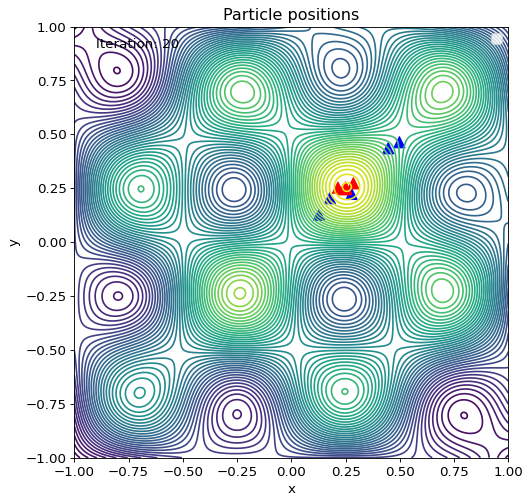

In [7]:
env.render(type="history", file_path="fig1.gif")

In [ ]:
def run_experiment(env, agent_policy, timesteps, iters, save_gif=False, result_path="experiment/", save_interval=10,
                   split_agents=True, threshold=0.1, save_surrogate_plots=False, sur_debug=False, number_of_points=6, 
                   decay_std=False):
    gbest_values = []
    if save_gif:
        os.makedirs(result_path, exist_ok=True)
    for iter in range(iters):
        print("Iteration: ", iter)
        observation_info = env.reset()
        episode_gbVals = []
        gp_Info = []
        for i in range(timesteps):
            if decay_std:
                agent_policy.std_controller.decay_std()
            agent_policy.std_controller.update_role(observation_info[1])
            observation_std = agent_policy.std_controller.get_all_std()
            if sur_debug:
                env.surrogate.plot_surrogate(save_dir=result_path + "iter_" + str(iter) + "_time_" + str(i) + "_mean.png")
                env.surrogate.plot_variance(save_dir=result_path + "iter_" + str(iter) + "_time_" + str(i) + "_variance.png")
                env.surrogate.plot_checkpoints_state(save_dir=result_path + "iter_" + str(iter) + "_time_" + str(i) + "_checkpoints.png")
                env.render(type="state", file_path=result_path + "iter_" + str(iter) + "_time_" + str(i) + "_state_.png")
            episode_gbVals.append(env.gbest[-1])
            exploiters_action =  get_action(observation_info[0], observation_std, agent_policy, env)
            explorer_action, next_point = get_informed_action(env, number_of_points=number_of_points)
            actions = np.zeros((env.n_agents, env.n_dim))
            actions[:(env.n_agents - number_of_points)] = exploiters_action[:(env.n_agents - number_of_points)]
            actions[(env.n_agents - number_of_points):] = explorer_action
            observation_info, reward, done, info = env.step(actions)

            if sur_debug:
                plot_point(env.grid_points, env.evaluated_points, next_point, save_dir=result_path + "iter_" + str(iter) + "_time_" + str(i) + "_points.png")
            if sur_debug:
                gp_Info.append(env.surrogate.gp.kernel_)
        gbest_values.append(episode_gbVals)
        if save_gif and iter % save_interval == 0:
            _ = env.render(type="history", file_path=result_path + "iter_" + str(iter) + ".gif")
        if save_surrogate_plots and iter % save_interval == 0:
            env.surrogate.plot_surrogate(save_dir=result_path + "iter_" + str(iter) + ".png")
            env.surrogate.plot_variance(save_dir=result_path + "iter_" + str(iter) + "_variance.png")
            env.surrogate.plot_checkpoints_state(save_dir=result_path + "iter_" + str(iter) + "_checkpoints.png")       

    return gbest_values, gp_Info